# 混合正規分布

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

In [2]:
mean1 = [0, 5] 
mean2 = [-3, -3]
mean3 = [3, -3]
cov1 = [[2., 0.], [0., 1.]]
cov2 = [[1., 0.5], [0.5, 1.]]
cov3 = [[1., -0.5], [-0.5, 2.]]
x1 = np.random.multivariate_normal(mean1, cov1, 50)
x2 = np.random.multivariate_normal(mean2, cov2, 50)
x3 = np.random.multivariate_normal(mean3, cov3, 50)
x_train = np.concatenate([x1, x2, x3])

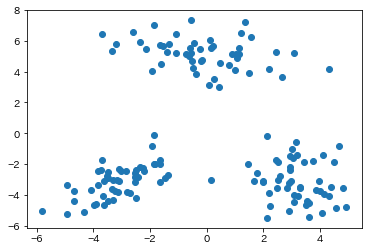

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1])

## 学習

混合ガウス分布はK個のガウス分布の重ね合わせとして表現される。$k$番目のガウス分布の混合割合を$\pi_{k}$とすると、以下のように書ける。

$p(\boldsymbol{x}) = \sum_{k=1}^{K} \pi_{k} \mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu_{k}}, \Sigma_{k})$

データ点$\boldsymbol{x}$がどのガウス分布から生成したかを表す潜在変数$\boldsymbol{z}$を導入しても同じような表現を得ることができる（$\boldsymbol{z}$は1-of-K表現であり、$z_{k}=1$は$k$番目のガウス分布からデータ点が生成されたことを意味する）。

具体的には$p(z_{k}=1) = \pi_{k}, \quad p(\boldsymbol{x} | z_{k}=1) = \mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu_{k}}, \Sigma_{k})$とすると、

$p(\boldsymbol{z}) = \prod_{k=1}^{K} \pi_{k}^{z_{k}}, \quad p(\boldsymbol{x} | \boldsymbol{z}) = \prod_{k=1}^{K} \mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu_{k}}, \Sigma_{k})^{z_{k}}$と書けるので、

$p(\boldsymbol{x}) = \sum_{z} p(\boldsymbol{x} | \boldsymbol{z}) p(\boldsymbol{z})$は上と同じ表現を得る。

訓練データに対して対数尤度関数は次のようになる。

$\log{L(\boldsymbol{\mu}, \Sigma, \boldsymbol{\pi})} = \sum_{n=1}^{N} \log{(\sum_{k=1}^{K} \pi_{k} \mathcal{N}(\boldsymbol{x}_{n} | \boldsymbol{\mu_{k}}, \Sigma_{k}))}$

$\boldsymbol{\mu}_{k}, \Sigma_{k}, \pi_{k}$それぞれに関して偏微分した値が$0$になる点を求めると、

$\hat{\boldsymbol{\mu}_{k}} = \frac{1}{N_{k}} \sum_{n=1}^{N} \gamma(z_{nk}) \boldsymbol{x}_{n}$

$\hat{\Sigma_{k}} = \frac{1}{N_{k}} \sum_{n=1}^{N} \gamma(z_{nk}) (\boldsymbol{x}_{n} - \hat{\boldsymbol{\mu}_{k}}) (\boldsymbol{x}_{n} - \hat{\boldsymbol{\mu}_{k}})^{\mathrm{T}}$

$\hat{\pi_{k}} = \frac{N_{k}}{N}$

ただし、$\gamma(z_{nk}) = \frac{\pi_{k} \mathcal{N}(\boldsymbol{x}_{n} | \boldsymbol{\mu_{k}}, \Sigma_{k})}{\sum_{k=1}^{K} \pi_{k} \mathcal{N}(\boldsymbol{x}_{n} | \boldsymbol{\mu_{k}}, \Sigma_{k})}, N_{k} = \sum_{n=1}^{N} \gamma(z_{nk})$である。$\gamma(z_{nk}) = p(z_{k}=1 | \boldsymbol{x}_{n})$は$z_{k}=1$の事後分布であり、負担率ともよばれる量である。

求めるパラメータ$\boldsymbol{\mu}_{k}, \Sigma_{k}, \pi_{k}$がそのパラメータ自身に依存するので、閉じた形の解として求められない。
そこでEMアルゴリズム（期待値最大化法）で解を求める。

EMアルゴリズムの手順は以下のとおりである。

1. パラメータ$\boldsymbol{\mu}_{k}, \Sigma_{k}, \pi_{k}$を初期化し、対数尤度を計算する。
2. (Eステップ) 現在推定されているパラメータを用いて負担率$\gamma(z_{nk})$を計算する。
3. (Mステップ) 現在の負担率を用いて、パラメータを再計算する。
4. 収束すれば終了。そうでなければ、2へ。

In [4]:
def gauss(X, mu, cov):
    K, d = mu.shape
    ret = np.zeros((len(X), K))
    for k in range(K):
        coef = 1 / ( np.sqrt((2 * np.pi)**d * np.linalg.det(cov[k])) )
        ret[:, k] = coef * np.exp(-0.5 * np.sum( np.dot(X - mu[k], np.linalg.inv(cov[k])) * (X - mu[k]), axis=1 ))
    return ret

def expectation(X, mu, cov, pi):
    # Eステップ
    gamma = pi * gauss(X, mu, cov)
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def maximization(X, gamma):
    # Mステップ
    Nk = np.sum(gamma, axis=0)
    pi = Nk / len(X)
    mu = (np.dot(X.T, gamma) / Nk).T
    
    K, d = mu.shape
    cov = np.zeros((K, d, d))
    for k in range(K):
        cov[k] = np.dot(gamma[:, k] * (X - mu[k]).T, X - mu[k]) / Nk[k]
    return mu, cov, pi

In [5]:
X = x_train
K = 3

# パラメータ初期化
mu = np.random.rand(K, x_train.shape[1])
cov = np.cov(X.T)
cov = np.array([cov for _ in range(K)])
pi = np.ones(K) / K

params = np.hstack(
    (mu.ravel(),
     cov.ravel(),
     pi.ravel())
)

while True:
    gamma = expectation(X, mu, cov, pi)
    mu, cov, pi = maximization(X, gamma)
    
    new_params = np.hstack(
        (mu.ravel(),
         cov.ravel(),
         pi.ravel())
    )
    if np.allclose(params, new_params):
        break
    else:
        params = new_params

## クラスタリング結果

$\gamma(\boldsymbol{z}) = p(\boldsymbol{z} | \boldsymbol{x})$は属するクラスの事後分布と考えることができるので、各データ点に対して、$\gamma$の値が大きい$k$が属するクラスである。

In [6]:
y_pred = gamma.argmax(axis=1)

In [7]:
xx0, xx1 = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
xx = np.array([xx0, xx1]).reshape(2, -1).T

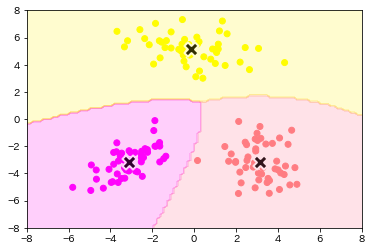

In [8]:
#　データを可視化
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_pred, cmap='spring')
# 中心を可視化
plt.scatter(mu[:, 0], mu[:, 1], s=200, marker='X', lw=2, c='black', edgecolor="white")
# 領域の可視化
pred = expectation(xx, mu, cov, pi).argmax(axis=1)
plt.contourf(xx0, xx1, pred.reshape(100, 100), alpha=0.2, cmap='spring')

## ガウス分布の等高線を可視化

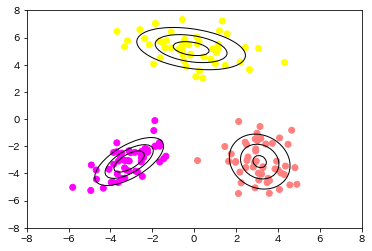

In [9]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_pred, cmap='spring')

from scipy.stats import multivariate_normal
for k in range(K):
    pdf = multivariate_normal.pdf(xx, mu[k], cov[k])
    plt.contour(xx0, xx1, pdf.reshape(100, 100), 3, colors='k', linewidths=1)